In [2]:
import numpy as np
import scipy.optimize
import astropy.units as u
import astropy.time
import astropy.constants
import astropy.coordinates
import pytz
import matplotlib.pyplot as plt

astropy.coordinates.solar_system_ephemeris.set("de430")

<ScienceState solar_system_ephemeris: 'de430'>

# Eclipse Prediction

In [3]:
# Compute angular distance between sun and moon
def distance_contact(
    location: astropy.coordinates.EarthLocation,
    time: astropy.time.Time
) -> u.Quantity:

    radius_sun = astropy.constants.R_sun
    radius_moon = 1737.4 * u.km

    coordinate_sun = astropy.coordinates.get_sun(time)
    coordinate_moon = astropy.coordinates.get_body("moon", time)

    frame_local = astropy.coordinates.AltAz(obstime=time, location=location)

    alt_az_sun = coordinate_sun.transform_to(frame_local)
    alt_az_moon = coordinate_moon.transform_to(frame_local)
    return alt_az_moon.separation(alt_az_sun).degree

# Compute overlap percentage between sun and moon
def overlap_percent(
    location: astropy.coordinates.EarthLocation,
    time: astropy.time.Time
) -> float:    
    radius_sun = astropy.constants.R_sun
    radius_moon = 1737.4 * u.km
    
    coordinate_sun = astropy.coordinates.get_sun(time)
    coordinate_moon = astropy.coordinates.get_body("moon", time)
    
    frame_local = astropy.coordinates.AltAz(obstime=time, location=location)
    
    alt_az_sun = coordinate_sun.transform_to(frame_local)
    alt_az_moon = coordinate_moon.transform_to(frame_local)

    sun_angle = np.arctan(radius_sun / alt_az_sun.distance)
    moon_angle = np.arctan(radius_moon / alt_az_moon.distance)
    separation = alt_az_moon.separation(alt_az_sun)
    
    sun_min = -sun_angle.value
    sun_max = sun_angle.value
    moon_min = (separation - moon_angle).rad
    moon_max = (separation + moon_angle).rad
    
    # The apparent size of the moon is slightly large than the sun
    return np.maximum(0.0, np.minimum(sun_max, moon_max) - np.maximum(sun_min, moon_min)) / (2 * sun_angle.value)

def cleveland():
    lat = 41.4993
    lon = -81.6944
    location = astropy.coordinates.EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=0 * u.m)
    timezone = astropy.time.TimezoneInfo(utc_offset=-4*u.hour)
    return location, timezone, astropy.time.Time("2024-04-07"), astropy.time.Time("2024-04-09")

def sobral():
    lat = -3.6844
    lon = -40.3562
    location = astropy.coordinates.EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=0 * u.m)
    timezone = astropy.time.TimezoneInfo(utc_offset=-3*u.hour, dst=0*u.hour)
    return location, timezone, astropy.time.Time("1919-05-28"), astropy.time.Time("1919-05-30")


In [ ]:
# Compute exact time of maximum eclipse

location, timezone, start, end = cleveland()

opt = scipy.optimize.minimize_scalar(
    fun=lambda t: distance_contact(location, astropy.time.Time(t, format="unix")),
    bracket=[start.unix, end.unix],
)
print(opt)
e_time = astropy.time.Time(opt.x, format="unix")
print(e_time.to_datetime(timezone))

coordinate_sun = astropy.coordinates.get_sun(e_time)
frame_local = astropy.coordinates.AltAz(obstime=e_time, location=location)
coordinate_sun = coordinate_sun.transform_to(frame_local)

In [ ]:
# Plot sun/moon a few days around the eclipse (as well as the eclipse point)

dt = 15 * u.day

plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title(f"Moon/Sun for {dt} around {e_time.to_datetime(timezone)}", pad=20)
plt.grid(True)

def plot(coord, *args, **kwargs):  
    az = coord.az.wrap_at(180 * u.deg).radian
    alt = coord.alt.radian
    plt.plot(az, alt, *args, **kwargs)

ts = np.linspace(astropy.time.Time(e_time - 0.5 * dt), astropy.time.Time(e_time + 0.5 * dt), 1000)
frame_locals = astropy.coordinates.AltAz(obstime=ts, location=location)
plot(astropy.coordinates.get_sun(ts).transform_to(frame_locals), 'o', markersize=3, alpha=1.0, c='y')
plot(astropy.coordinates.get_body("moon", ts).transform_to(frame_locals), 'o', markersize=1, alpha=1.0, c='b')
plot(astropy.coordinates.get_sun(e_time).transform_to(astropy.coordinates.AltAz(obstime=e_time, location=location)), 'x', markersize=5, alpha=1.0, c='r')

plt.show()

In [234]:
# Makes queries against the National Weather Service API to get cloud cover
from datetime import datetime

import time
import urllib.request
import urllib.error
import json 
import pandas as pd
import bisect
import pytz

def _query_with_retry(query, retries=5):
    count = 0
    sleep = 1
    while count < retries:
        count += 1
        try:
            with urllib.request.urlopen(query) as url:
                return json.load(url)
        except urllib.error.HTTPError as e:
            if e.code == 404:
                print(f"Unable to make query {query}")
                raise e
            if e.code == 500:
                print(f"{e}, retrying in {sleep}s")
                time.sleep(sleep)
                sleep *= 1.5
                continue
    raise Exception("Timeout, unable to make query")
                
def query_sky_cover(lat, lon, query_time):
    print (f"Querying at {lat}, {lon} t={query_time}")

    data = _query_with_retry(f"https://api.weather.gov/points/{lat},{lon}")
    tz = pytz.timezone(data["properties"]["timeZone"])
    forecast_url = data["properties"]["forecastGridData"]
    data = _query_with_retry(forecast_url)

    query_time = query_time.to_datetime(timezone=tz)
    dates = [datetime.fromisoformat(v["validTime"].split("/")[0]) for v in data["properties"]["skyCover"]["values"]]
    i = bisect.bisect_left(dates, query_time)
    if i > 0:
        return data["properties"]["skyCover"]["values"][i - 1]["value"]
    
    # Unable to find anything
    raise "Unable to find forecast"

def query_sky_cover_safe(lat, lon, t):
    try:
        return query_sky_cover(lat, lon, t)
    except:
        print(f"No data for {lat} {lon}")
        return 100

In [129]:
import googlemaps

def get_travel_time(orig_lat, orig_lon, dest_lat, dest_lon, query_time):
    directions_result = gmaps.directions(f"{orig_lat},{orig_lon}", f"{dest_lat},{dest_lon}", mode="driving", departure_time=query_time)
    return directions_result[0]['legs'][0]['duration_in_traffic']['value'] * u.s

def get_travel_times(orig_lat, orig_lon, destinations, query_time):
    results = []
    s = ""
    for i, dest in enumerate(destinations):
        s += f"{dest[0]},{dest[1]}|"

        # Can only make a handful of queries per call
        if i + 2 < len(destinations) and (i == 0 or i % 20 != 0):
            continue
        s = s[:-1]
        directions_result = gmaps.distance_matrix(f"{orig_lat},{orig_lon}", s, mode="driving", departure_time=query_time)
        for element in directions_result['rows'][0]['elements']:
            if 'duration_in_traffic' in element:
                results.append((float(element['duration_in_traffic']['value']) * u.s).to(u.hr).value)
            else:
                results.append(0.0)
        s = ""
    return results

lat0, lon0 = 40.4406,-79.9959
lat1, lon1 = 41.4406,-79.9959
lat2, lon2 = 41.4406,-78.9959
get_travel_times(lat0, lon0, [[lat1, lon1], [lat2, lon2]], datetime.now())

[1.3652777777777778, 2.1894444444444443]

920 totality points loaded


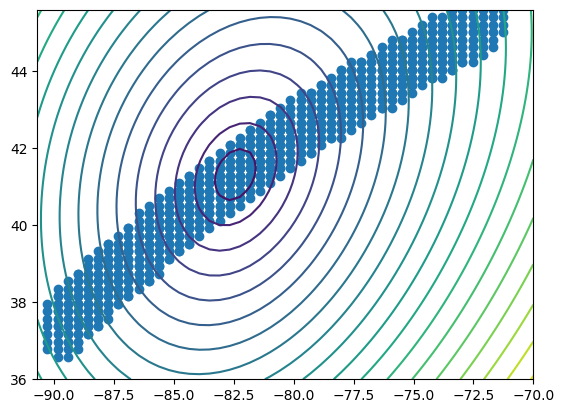

In [250]:
# Generate points within totality along the path of the eclipse

from datetime import datetime, timezone

center_time = astropy.time.Time("2024-04-08 19:14:30")

lat_min, lon_min = 36.0, -90.7
lat_max, lon_max = 45.6, -70.0
lat_center = lat_min + (lat_max - lat_min) / 2.0
lon_center = lon_min + (lon_max - lon_min) / 2.0

points = 50
lats = np.linspace(lat_min, lat_max, points)
lons = np.linspace(lon_min, lon_max, points)
lat, lon = np.meshgrid(lats, lons)

dt = 15 * u.min
count = 20
centers = []
center_ts = []
ts = np.linspace(center_time - dt, center_time + dt, count)
for t in ts:
    locations = astropy.coordinates.EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=0 * u.m)
    overlap = overlap_percent(locations, t)
    indicies = overlap > 0.999
    for x, y in zip(lat[indicies], lon[indicies]):
        centers.append([x, y])
        center_ts.append(t)
    
centers = np.array(centers)
print(f"{len(centers)} totality points loaded")
plt.scatter(centers[:, 1], centers[:, 0])

locations = astropy.coordinates.EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=0 * u.m)
overlap = distance_contact(locations, center_time)
plt.contour(lon, lat, overlap, 20)
plt.show()

In [236]:
# Query weather across the map
import time

points = 15
cloud_lats = np.linspace(lat_min, lat_max, points)
cloud_lons = np.linspace(lon_min, lon_max, points)
cloud_lat, cloud_lon = np.meshgrid(cloud_lats, cloud_lons)

# Assume times are nearby
avg_t = ts[len(ts) // 2]

cover = np.zeros_like(cloud_lat)

t0 = time.time()
for i in range(cloud_lat.shape[0]):
    print(f"Querying i={i} Last iteration was { time.time() - t0}s")
    t0 = time.time()
    for j in range(cloud_lat.shape[1]):
        cover[i, j] = query_sky_cover_safe(cloud_lat[i, j], cloud_lon[i, j], avg_t)

weather_time = datetime.now()

# Query weather at each point within totality
center_covers = []
t0 = time.time()
for i, c in enumerate(centers):
    center_covers.append(query_sky_cover_safe(c[0], c[1], center_ts[i]))

    sample_rate = 20
    if i % sample_rate == 0:
        print(f"Making {sample_rate / (time.time() - t0)} queries/s")
        t0 = time.time()

center_covers = np.array(center_covers)

Querying i=0 Last iteration was 5.7220458984375e-05s
Querying at 36.0, -90.7 t=2024-04-08 19:02:28.421
HTTP Error 500: Internal Server Error, retrying in 1s
Querying at 36.68571428571428, -90.7 t=2024-04-08 19:02:28.421
Querying at 37.371428571428574, -90.7 t=2024-04-08 19:02:28.421
Querying at 38.05714285714286, -90.7 t=2024-04-08 19:02:28.421
HTTP Error 500: Internal Server Error, retrying in 1s
Querying at 38.74285714285714, -90.7 t=2024-04-08 19:02:28.421
Querying at 39.42857142857143, -90.7 t=2024-04-08 19:02:28.421
Querying at 40.114285714285714, -90.7 t=2024-04-08 19:02:28.421
Querying at 40.8, -90.7 t=2024-04-08 19:02:28.421
Querying at 41.48571428571429, -90.7 t=2024-04-08 19:02:28.421
Querying at 42.17142857142857, -90.7 t=2024-04-08 19:02:28.421
Querying at 42.85714285714286, -90.7 t=2024-04-08 19:02:28.421
Querying at 43.542857142857144, -90.7 t=2024-04-08 19:02:28.421
HTTP Error 500: Internal Server Error, retrying in 1s
Querying at 44.22857142857143, -90.7 t=2024-04-08 19

In [235]:
# Query weather at each point within totality
center_traffic = []
pit_lat, pit_lon = 40.4406, -79.9959
center_traffic = get_travel_times(pit_lat, pit_lon, centers, datetime.now())
center_traffic = np.array(center_traffic)
print(center_traffic)

[11.74527778 11.80472222 11.60444444 11.42888889 11.49111111 11.44333333
 11.07444444 11.35388889 11.49361111 11.12888889 10.85666667 11.60444444
 11.42888889 11.49111111 11.44333333 11.07472222 10.89166667 10.66194444
 10.35527778 11.49361111 11.12888889 10.85666667 11.17333333 11.16305556
 10.61916667 10.46916667 10.27611111 10.21166667 10.9425     10.81444444
 10.53861111 10.65777778 10.62583333 10.67805556 10.4175     10.10027778
  9.82944444  9.72083333 10.56777778 10.27611111 10.23638889 10.11138889
 10.40416667 10.19388889  9.78027778  9.45333333  9.47166667  9.57944444
  9.64222222  9.35472222  9.235      10.40416667 10.19388889  9.78027778
  9.45333333  9.27        8.98694444  8.77833333  9.57944444  9.64222222
  9.35472222  9.235       9.02944444  8.8575      8.61194444  8.36527778
  8.22416667  9.31527778  9.44583333  9.10527778  8.9125      8.78111111
  8.51666667  8.38972222  8.51805556  8.23055556  7.83805556  8.93027778
  8.995       8.63638889  8.36416667  8.14222222  8

/var/folders/7p/qx5tv9ln5yz4c1cpvz_nx3qc0000gn/T/ipykernel_20747/2224730932.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=max_hours), cmap=green_red), shrink=0.4, anchor=(-0.8, 0.5))


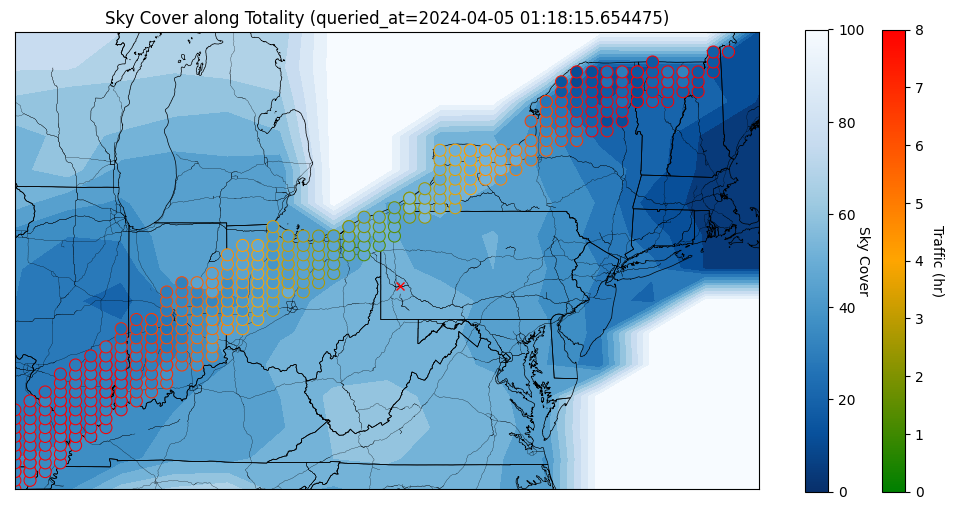

In [240]:
# Plot the map, eclipse points, and weather

from mpl_toolkits.basemap import Basemap
import matplotlib

plt.figure(figsize=(15, 15))

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
            lat_0=lat_center, lon_0=lon_center, projection='merc')

m.readshapefile('assets/cb_2018_us_state_500k/cb_2018_us_state_500k', 'states', drawbounds=True)
m.readshapefile('assets/tl_2017_us_primaryroads/tl_2017_us_primaryroads', 'roads', drawbounds=True, linewidth=0.1)

y, x = m(cloud_lon, cloud_lat)
plt.contourf(y, x, cover, 15, cmap='Blues_r', vmin=0, vmax=100)

y, x = m(centers[:, 1], centers[:, 0])
mask = np.logical_and(center_covers < 100, center_traffic > 0)
green_red = matplotlib.colors.LinearSegmentedColormap.from_list('gr',["g", "orange", "r"], N=256) 
max_hours = 8.0
edge_colors = green_red(center_traffic[mask] / max_hours)
plt.scatter(y[mask], x[mask], c=center_covers[mask], s=75, cmap='Blues_r', vmin=0, vmax=100, edgecolors=edge_colors, linewidth=0.75, zorder=2)

cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=max_hours), cmap=green_red), shrink=0.4, anchor=(-0.8, 0.5))
cbar.set_label('Traffic (hr)', rotation=270, labelpad=15)
cbar = plt.colorbar(shrink=0.4)
cbar.set_label('Sky Cover', rotation=270)

y, x = m(pit_lon, pit_lat)
plt.plot(y, x, 'x', c='r')

plt.title(f"Sky Cover along Totality (queried_at={weather_time})")

plt.show()

# Eclipse Stars

In [589]:
from astroquery.gaia import Gaia

ra_column_name = Gaia.MAIN_GAIA_TABLE_RA
dec_column_name = Gaia.MAIN_GAIA_TABLE_DEC
row_limit = 100
columns = "*" #"phot_g_mean_mag, ra, dec, name"
radiusDeg = 1.0

# from astroquery.commons.coord_to_radec()
coord = astropy.coordinates.SkyCoord(az=coordinate_sun.az, alt=coordinate_sun.alt, frame=frame_local).transform_to('fk5')
ra = coord.ra.degree
dec = coord.dec.degree
query = """
        SELECT
          {row_limit}
          {columns},
          DISTANCE(
            POINT('ICRS', {ra_column}, {dec_column}),
            POINT('ICRS', {ra}, {dec})
          ) AS dist
        FROM
          gaiadr3.gaia_source
        WHERE
          1 = CONTAINS(
            POINT('ICRS', {ra_column}, {dec_column}),
            CIRCLE('ICRS', {ra}, {dec}, {radius})
          )
        ORDER BY
          phot_g_mean_mag ASC
        """.format(**{'ra_column': ra_column_name,
                      'row_limit': "TOP {0}".format(row_limit),
                      'dec_column': dec_column_name,
                      'columns': columns,
                      'ra': ra,
                      'dec': dec,
                      'radius': radiusDeg})

print (query)
job = Gaia.launch_job(query)
print(job)
stars = job.get_results()


        SELECT
          TOP 100
          *,
          DISTANCE(
            POINT('ICRS', ra, dec),
            POINT('ICRS', [98.03663789], [6.67861475])
          ) AS dist
        FROM
          gaiadr3.gaia_source
        WHERE
          1 = CONTAINS(
            POINT('ICRS', ra, dec),
            CIRCLE('ICRS', [98.03663789], [6.67861475], 1.0)
          )
        ORDER BY
          phot_g_mean_mag ASC
        


HTTPError: Error 400: 
Cannot parse query '
        SELECT
          TOP 100
          *,
          DISTANCE(
            POINT('ICRS', ra, dec),
            POINT('ICRS', [98.03663789], [6.67861475])
          ) AS dist
        FROM
          gaiadr3.gaia_source
        WHERE
          1 = CONTAINS(
            POINT('ICRS', ra, dec),
            CIRCLE('ICRS', [98.03663789], [6.67861475], 1.0)
          )
        ORDER BY
          phot_g_mean_mag ASC
        ' for job '1711634617460O': Encountered " &lt;UNSIGNED_FLOAT> ".03663789 "" at line 7, column 30.
Was expecting one of:
    "." ...
    "," ...
    "+" ...
    "-" ...
    "*" ...
    "/" ...
    "." ...
    "*" ...
    "/" ...
    "+" ...
    "-" ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    "," ...
    


In [590]:
coord = astropy.coordinates.SkyCoord(ra=stars['ra'][0] * u.deg, dec=stars['dec'][0] * u.deg, frame='icrs')
print("ICRS stars", coord.icrs)
print("ICRS sun", coordinate_sun.icrs)
print("AltAz star", coord.transform_to(frame_local))
print("AltAz sun", coordinate_sun.transform_to(frame_local))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [591]:
coordinate_stars = astropy.coordinates.SkyCoord(ra=stars['ra'], dec=stars['dec'], frame='icrs').transform_to(frame_local)

# https://en.wikipedia.org/wiki/Gravitational_lens
def deflection(coords):
    rs = 2 * astropy.constants.G * astropy.constants.M_sun / astropy.constants.c**2
    r = astropy.constants.au * np.tan(coordinate_stars.separation(coordinate_sun).rad)
    return -2 * rs / r * u.rad

position_angle = coordinate_stars.position_angle(coordinate_sun)
coordinate_stars_offset = coordinate_stars.directional_offset_by(position_angle, deflection(coordinate_stars))

print (coordinate_stars_offset.separation(coordinate_stars).degree)
print (coordinate_stars_offset)
print (coordinate_stars)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

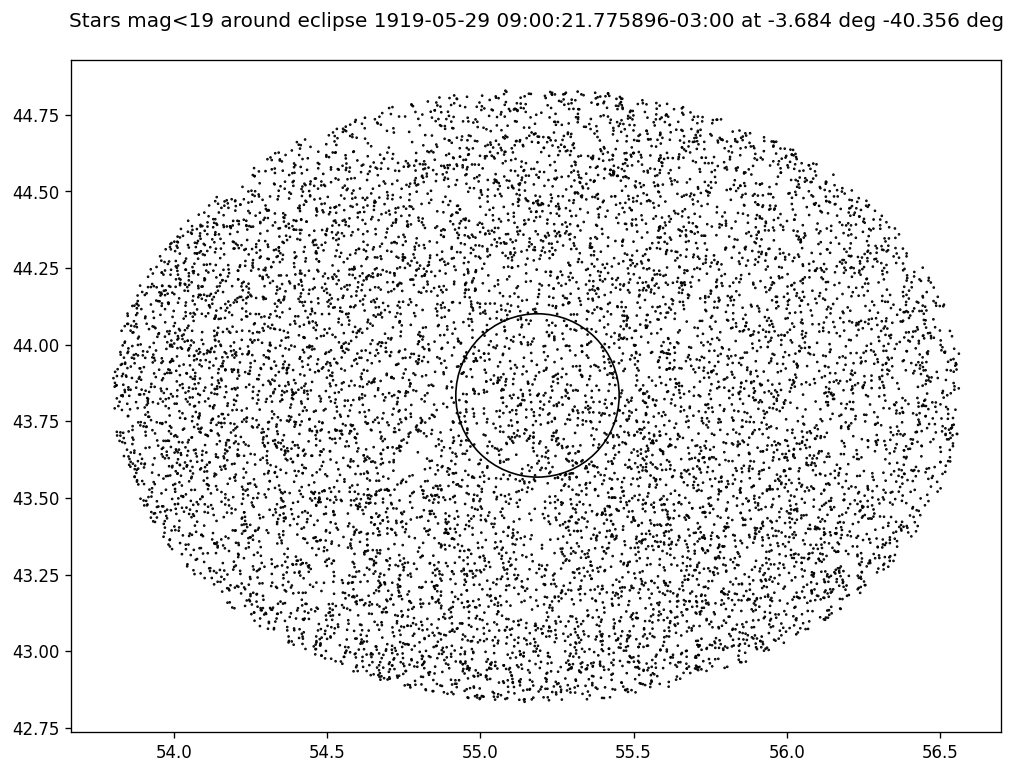

In [269]:
import matplotlib.pyplot as plt

mag_threshold = 19

plt.figure(figsize=(10, 10), dpi=120)
plt.title(f"Stars mag<{mag_threshold} around eclipse {e_time.to_datetime(timezone)} at {location.lat:.3f} {location.lon:.3f}", pad=20)
#plt.grid(True)

def plot(coord, *args, **kwargs):
    az = coord.az.wrap_at(180 * u.deg).degree
    alt = coord.alt.degree
    plt.scatter(az, alt, *args, **kwargs)
    
sun = astropy.coordinates.get_sun(e_time).transform_to(frame_local)

mask = stars['phot_g_mean_mag'] < mag_threshold
sizes = 1.0 / np.log(stars[mask]['phot_g_mean_mag'])
#plot(coordinate_stars_offset[mask], 'x', markersize=1, alpha=1.0, c='red')
plot(coordinate_stars[mask], alpha=1.0, c='black', s=sizes)

plot(coordinate_sun, s=1.0, marker='x', color='black')
plt.gca().add_patch(plt.Circle((sun.az.wrap_at(180 * u.deg).degree, sun.alt.degree), sun_angle.to("deg").value, ec='black', fc='none', lw=1.0, zorder=2))

plt.gca().set_aspect('equal')
plt.show()

# Simbad Stars

In [323]:
from astroquery.simbad import Simbad

Simbad.ROW_LIMIT = 15 # now any query fetches at most 15 rows

# Initialize Simbad
simbad = Simbad()
simbad.add_votable_fields('flux(V)', 'ra(d)', 'dec(d)')

# Define the RA/Dec coordinates in ICRS and search radius
radius = 10 * u.arcminute  # Define the search radius
query = astropy.coordinates.SkyCoord(az=coordinate_sun.az, alt=coordinate_sun.alt, frame=frame_local).transform_to('fk5')

# Perform the query
print("Querying...")
result = simbad.query_region(query, radius=2 * u.degree)
print("Done!")

Querying...
Done!


In [334]:
print(result[result["FLUX_V"] < 6]["MAIN_ID"])
coord = astropy.coordinates.SkyCoord(ra=result['RA_d'], dec=result['DEC_d'], unit=(u.deg, u.deg), frame='icrs')
print(coord)

 MAIN_ID 
---------
* alf UMi
<SkyCoord (ICRS): (ra, dec) in deg
    [(37.95456067, 89.26410897)]>


In [580]:
from astroquery.simbad import Simbad

# Initialize Simbad
simbad = Simbad()
simbad.add_votable_fields('flux(V)', 'ra(d)', 'dec(d)', 'ids')

objects = [
    # Orion
    "Betelgeuse", "Rigel", "Bellatrix", "Mintaka", "Alnilam", "Alnitak", "Saiph", "Meissa",
    # North Star
    "Polaris",
    # Big dipper
    "Dubhe", "Merak", "Phecda", "Megrez", "Alioth", "Mizar", "Alkaid",
]


result = simbad.query_objects(objects)
print(f"Loaded {len(result)} record(s)")

print(result["FLUX_V"])
print(f"Filtered down to {len(result)} record(s)")

stars = astropy.coordinates.SkyCoord(ra=result['RA_d'], dec=result['DEC_d'], unit=(u.deg, u.deg), frame='icrs')

Loaded 16 record(s)
FLUX_V
 mag  
------
  0.42
  0.13
  1.64
  2.41
  1.69
  1.77
  2.06
  3.66
  2.02
  1.79
  2.37
  2.44
  3.32
  1.77
    --
  1.86
Filtered down to 16 record(s)


/Users/mattlangford/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


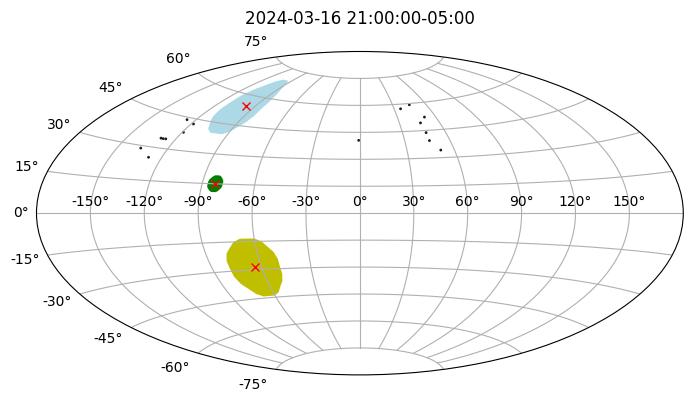

In [581]:
from datetime import datetime

# Pittsburgh
lat = 40.4406
lon = -79.9959
location = astropy.coordinates.EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=0 * u.m)
timezone = astropy.time.TimezoneInfo(utc_offset=-5*u.hour, dst=1*u.hour)
local_time = astropy.time.Time(datetime(2024, 3, 16, 21, 0, 0, tzinfo=timezone))

n_hours = 2
count = 1
ts = np.linspace(local_time, local_time + count * n_hours * u.hour, count)
frame_local = astropy.coordinates.AltAz(obstime=ts, location=location)

plt.figure(figsize=(10, 4.2))
plt.subplot(111, projection="aitoff")
plt.title(f"", pad=20)
plt.grid(True)

def coordinate_transform(coord):
    coord = coord.transform_to(frame_local)
    az = coord.az.wrap_at(180 * u.deg).radian
    alt = coord.alt.radian
    return az, alt

def plot(coord, *args, **kwargs):
    az, alt = coordinate_transform(coord)
    plt.scatter(az, alt, *args, **kwargs)
    
def labels(coord, labels, *args, **kwargs):
    az, alt = coordinate_transform(coord)
    for i in range(len(az)):
        plt.gca().annotate(labels[i], (az[i], alt[i]), *args, **kwargs)

def plot_circles(coord, radius, *args, **kwargs): 
    azs, alts = coordinate_transform(coord)
    for (az, alt) in zip(azs, alts):
        plt.gca().add_patch(plt.Circle((az, alt), radius.to("deg").value, *args, **kwargs))
    plt.plot(azs[0], alts[0], 'x', c="red")

sun = astropy.coordinates.get_sun(ts).transform_to(frame_local)
sun_angle = np.arctan(astropy.constants.R_sun / np.mean(sun.distance))
plot_circles(sun, sun_angle, facecolor='y')

moon = astropy.coordinates.get_body("moon", ts).transform_to(frame_local)
moon_angle = np.arctan(1737.4 * u.km / np.mean(moon.distance))
plot_circles(moon, moon_angle, facecolor='lightblue')

jupiter = astropy.coordinates.get_body("jupiter", ts).transform_to(frame_local)
jupiter_angle = np.arctan(69911 * u.km / np.mean(jupiter.distance))
plot_circles(jupiter, 0.075 * u.deg, facecolor='g')


plot(stars, s=1, color=[(0.1, 0.1, 0.1)] * len(stars))

if count > 1:
    plt.title(f"Every {n_hours} hours from {local_time.to_datetime(timezone)}", pad=20)
else:
    plt.title(f"{local_time.to_datetime(timezone)}", pad=20)
    
plt.show()

In [582]:
result = simbad.query_criteria("Vmag < 3")
print(result)

print(f"Filtered down to {len(result)} record(s)")
stars = astropy.coordinates.SkyCoord(ra=result['RA_d'], dec=result['DEC_d'], unit=(u.deg, u.deg), frame='icrs')

  MAIN_ID         RA      ... SCRIPT_NUMBER_ID
               "h:m:s"    ...                 
----------- ------------- ... ----------------
  * tet Cen 14 06 40.9475 ...                0
  * del Cap 21 47 02.4442 ...                0
  * tet Aur 05 59 43.2701 ...                0
  * eta CMa 07 24 05.7022 ...                0
  * eta Peg 22 43 00.1288 ...                0
  * mu. Gem 06 22 57.6268 ...                0
  * del Oph 16 14 20.7385 ...                0
* zet Ori A 05 40 45.5271 ...                0
  * alf Cas 00 40 30.4410 ...                0
* alf02 CVn 12 56 01.6655 ...                0
  * alf Eri 01 37 42.8454 ...                0
  * bet Hyi 00 25 45.0703 ...                0
        ...           ... ...              ...
* zet01 UMa 13 23 55.5422 ...                0
  * bet Cet 00 43 35.3709 ...                0
* zet Her A 16 41 17.4649 ...                0
* alf02 Lib 14 50 52.7130 ...                0
  * gam Cas 00 56 42.5310 ...                0
  * gam UMa 1

In [607]:
# Pittsburgh
lat = 40.469150
lon = -79.959760

location = astropy.coordinates.EarthLocation(lat=lat * u.deg, lon=lon * u.deg, height=0 * u.m)
timezone = astropy.time.TimezoneInfo(utc_offset=-5*u.hour, dst=1*u.hour)
local_time = astropy.time.Time.now()

observer_gcrs = location.get_gcrs(local_time)
observer_bcrs = observer_gcrs.transform_to(astropy.coordinates.BarycentricMeanEcliptic())

print(observer_bcrs.cartesian.x)
print(observer_bcrs.cartesian.y)
print(observer_bcrs.cartesian.z)

-147670733854.16623 m
-29987292396.46246 m
35474172.211164474 m


# JPL Queries

In [598]:
from astroquery import jplhorizons

local_time = astropy.time.Time.now()

location = "@0"
epochs = {'start': "2024-01-01", 'stop': "2024-06-01", 'step': '1day'}

#print(jplhorizons.Horizons(id='sun', location=location, epochs=epochs).ephemerides())

sun = jplhorizons.Horizons(id='sun', location=location, epochs=epochs).vectors()
earth = jplhorizons.Horizons(id='399', location=location, epochs=epochs).vectors()
moon = jplhorizons.Horizons(id='301', location=location, epochs=epochs).vectors()
jwst = jplhorizons.Horizons(id='-170', location=location, epochs=epochs).vectors()
mars = jplhorizons.Horizons(id='499', location=location, epochs=epochs).vectors()

print("Data loaded!")

Data loaded!


starting...


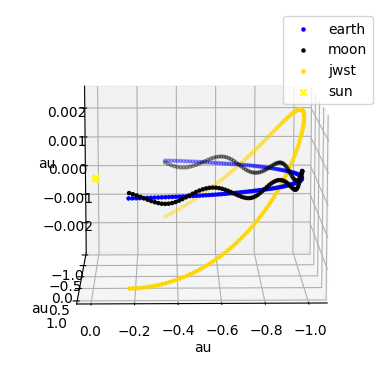

done


In [599]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for tbl, color, lbl in [(earth, 'b', 'earth'), (moon, 'black', 'moon'), (jwst, 'gold', 'jwst')]:
    ax.scatter(tbl['x'], tbl['y'], tbl['z'], marker='.', color=color, label=lbl)

ax.scatter(sun['x'], sun['y'], sun['z'], marker='x', color='yellow', label='sun')
ax.set_xlabel('au')
ax.set_ylabel('au')
ax.set_zlabel('au')
ax.legend()

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

from matplotlib import animation
anim = animation.FuncAnimation(fig, animate, frames=90, interval=20, blit=True)

writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
print("starting...")
anim.save('jwst.gif', writer=writer)
plt.show()
print("done")